# Salary Predictions Based on Job Descriptions

## Table of contents

### 1. Introduction
* The dataset, features and target value.
* Problem description.
   
### 2. Data quality check
* Libraries import and default configuration.
* Classes definition.
* Data load, merge, inspection and cleaning.

### 3. Descriptive statistics
* General overview.
* Features distribution.
* Correlation matrix.

### 4. Exporatory data analysis
* Features statistics analysis.

### 5. Data pre-processing
* Feature engeenering, categorical features and data normalization.

### 6. Model development
* Baseline.
* Best model selection, feature importance and predictions.

## 1. Introduction

### The dataset, features and target value

The data is split into 2 CSV files to train the model, one with the features and one with the target variable. The features are the descriptions of the jobs of a group of companies, being the columns the following:

* **jobId:** The ID of the job.
* **companyId:** The ID of the company.
* **jobType:** The description of the job.
* **degree:** The degree of the employee.
* **major:** The university or college field of specialization of the employee.
* **industry:** The field to which the company belongs.
* **yearsExperience:** The employee years of experience on the job.
* **milesFromMetropolis:** The distance in miles, the employee lives away from his/her place of work.

The target variable is the salary each employee receives, being the columns the following:

* **jobId:** The ID of the job.
* **salary:** Salary amount paid for that job.

### Problem description

As we know, the job market is very complex and competitive. For those who want to be hired, and for the companies which want to have the best talent at their service. Knowing how much are you going to get or pay for a certain job or profile, van be helpful for both the employee and the employer.

**_With the data available, can we develop a model that predicts the salary for a specific job and profile? How accurate can we get? Are the features enough for a good predictive model?_**

We will work to develop a machine learning model, that will try to predict the salaries accurately as possible, for each job in the test file.

In [1]:
__author__ = "Juan Vicente Peluso"
__email__ = "vpeluso@gmail.com"

### 2. Data quality check

* **Libraries import and default configuration.**

In [2]:
# Import necessary libraries
import os
import re
import math
import itertools
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
from zipfile import ZipFile
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
%matplotlib inline

# Ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings('ignore')

# Default configurations (Pandas and colors for the graphs)
rndSt = 16
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
tab10C = plt.get_cmap('tab10', 10)
pieColors = tab10C(np.linspace(0, 1, 10))
scatColor = ['Blues', 'Greens', 'Reds', 'Purples']
plotColor = ['b','g','r','m','y', 'silver', 'cadetblue', 
             'yellowgreen', 'darksalmon']
print('Libraries imported and default configuration set!')

Libraries imported and default configuration set!


* **Classes definition**

To see the classes documentation, please click [here](myData/classHelp.txt)

In [3]:
class dataHandler():
    
    '''Class that loads, process and transform the data.'''
    
    def __init__(self, trainFile, targFile, testFile, predFile, targCol = '', 
                 printI = True):
        self.trainFile = trainFile
        self.targFile = targFile
        self.testFile = testFile
        self.targCol = targCol
        self.predFile = predFile
        self.printI = printI
        self.numCols = ['yearsExperience','milesFromMetropolis']
        self.catCols = ['jobId','companyId','jobType','degree','major','industry']

    def allTasks(self, dupC = ''):
        self.train = self.loadCsv(self.trainFile)
        self.targ = self.loadCsv(self.targFile)
        self.test = self.loadCsv(self.testFile)
        self.trainN = pd.DataFrame()
        self.testN = pd.DataFrame()
        print('Files loaded in dataframes')
        self.train = self.mergeDF(self.train, self.targ, self.targCol)
        print('Train datasets merged\n\n### Checking Train dataframe ###\n')
        self.checkAll(self.train, zeroTarg = True, zeroCol = self.targCol, 
                      Del = True, printI = self.printI, dupC = dupC)
        print('\n### Checking Test dataframe ###\n')
        self.checkAll(self.test, zeroTarg = False, printI = self.printI, dupC = dupC)
        self.trainC = self.train.copy()

    def loadCsv(self, fileName):
        df = pd.read_csv(fileName)
        return df

    def mergeDF(self, df1, df2, df2Cols):
        df = df1.join(df2[df2Cols])
        return df

    def checkAll(self, df, zeroTarg = False, zeroCol = '', Del = False, printI = False, dupC = ''):
        try:
            if isinstance(df, pd.DataFrame) : DF = df
        except:
            print('The file recieved isn\'t a Pandas Dataframe')

        if printI : self.printInfo(DF)
        self.printShape(DF)
        self.checkNaN(DF, Del)
        self.checkDup(DF, Del, dupC)
        if zeroTarg : 
            zeroReg = self.zeroCol(DF, zeroCol)
            if zeroReg[0] > 0 :
                self.dropRows(self.train, zeroReg[1])
                self.dropRows(self.targ, zeroReg[1])
                print('@@@ {} = 0 rows successfully deleted @@@'.format(zeroCol))
    
    def objectCheck(self, df, limitV, dType):
        self.uniqCat(df, limitV)
        print('\n')
        return df.astype(dType).describe().transpose()

    def printShape(self, df):
        print('Dataframe shape\n---------------')
        print('{}\n'.format(df.shape))

    def printInfo(self, df):
        print('Dataframe information\n---------------------')
        print('{}\n'.format(df.info()))

    def checkNaN(self, df, Del = False):
        nan = np.sum(df.isna().sum())
        print('NaN values\n----------')
        if nan > 0:
            if Del:
                df.dropna()
                print('{} rows with NaN values\nNaN rows successfully deleted\n'.format(nan))
            else : print('{} rows with NaN values\n'.format(nan))
        else : print('{} rows with NaN values\n'.format(nan))


    def checkDup(self, df, Del = False, dupC = ''):
        dup = df.duplicated(subset = dupC).sum()
        print('Duplicated rows\n---------------')
        if dup > 0:
            if Del:
                df.drop_duplicates(subset = dupC)
                print('{} duplicated rows\nDuplicated rows successfully deleted\n'.format(dup))
            else : print('{} duplicated rows\n'.format(dup))
        else : print('{} duplicated rows\n'.format(dup))

    def zeroCol(self, df, col):
        zeros = df[df[col] <= 0].count()[0]
        print('{} == 0 (zero) validation'.format(col))
        print('{}-----------------------'.format('-'*int(len(col))))
        print('{} rows with value = 0'.format(zeros))
        if zeros > 0:
            return [zeros, list(df[df[col] <= 0].index)]
        else: return [0,[]]

    def dropRows(self, df, indexList):
        df.drop(indexList, inplace = True)
        df.reset_index(inplace = True, drop = True)
    
    def dropCols(self, df, colName):
        df.drop(colName, axis = 1, inplace=True)
        
    def updDtype(self, col, asT = 'str'):
        data.train[col] = data.train[col].astype(asT)
        data.test[col] = data.test[col].astype(asT)
        
    def uniqCat(self, df, limitV):
        for item in self.catCols:
            if len(df[item].unique()) < limitV :
                print('{} --> {}'.format(item, list(df[item].unique())))
    
    def aggData(self, df, group, agg, aggM, sort = '', sortL = [], asc = True):
        DF = df.groupby(group).agg({agg : aggM}).reset_index()
        if len(sort)>0 : DF.sort_values(by=sort, ascending=asc, inplace=True)
        if len(sortL)>0 : DF.sort_values(by=sortL, ascending=asc, inplace=True)
        return DF
    
    def pivotData(self, df, index, col, val):
        return df.pivot(index=index, columns=col, values=val)
    
    def rangeAnalysis(self, df1, df1Col, df2):
        txt = 'mean salary per company -->'
        diff = df1[df1Col].max()-df1[df1Col].min()
        print('Min {}{:.2f}'.format(txt, df1[df1Col].min()))
        print('Max {}{:.2f}'.format(txt, df1[df1Col].max()))
        print('Range between --> {:.2f}'.format(diff))
        df2['Min'] = df2.min(axis=1)
        df2['Max'] = df2.max(axis=1)
        df2['Range'] = df2['Max'] - df2['Min']
        df2.sort_values(by='Range', ascending = False)
        txt = 'Salary range mean per company and jobType -->'
        print('{} {:.2f}\n'.format(txt, df2['Range'].mean()))
        df3 = df2[['Min', 'Max', 'Range']].reset_index()
        df3.set_index('jobType', inplace=True)
        return df3

In [4]:
class plotGraph:
    
    '''Class that draw plots'''
    
    def __init__(self):
        self.setStyle()

    def setStyle(self, style = 'darkgrid'):
        sns.set(style = style)
    
    def plotDist(self, arr, fig, title, bins = 0, lblFS = 11, plotC = 'skyblue', yLbl = ''):
        
        if bins == 0 :
            ds = sns.distplot(arr, kde=False, color = plotC)
        else :
            ds = sns.distplot(arr, kde=False, color = plotC, bins = bins)
            
        plt.title(title, fontsize = 13)   
        plt.xlabel('')
        plt.ylabel(yLbl)
        plt.tick_params(top=False, bottom=True, left=True, right=False)
        plt.tick_params(axis='both', which='major', labelsize=lblFS)

    def plotPie(self, arr, fig, colors, title, titleFS = 12, pieFS = 10, 
                startA = 90, pct = False, pctD = 0.7, legLoc = 0):
        
        self.setStyle('white')
        if pct : 
            _ = plt.pie(arr, autopct='%1.1f%%', startangle=startA, colors = colors, pctdistance=pctD, 
                        textprops={'size': pieFS, 'weight' : 'semibold'}, wedgeprops={'alpha' : 0.65})
        else :
             _ = plt.pie(arr, startangle=startA, colors = colors,
                        textprops={'size': pieFS, 'weight' : 'semibold'}, wedgeprops={'alpha' : 0.65})
                
        plt.axis('off')
        fig.axis('equal') 
        plt.title('Distribution : {}'.format(item), fontsize=titleFS)
        
        if legLoc == 0 :
            plt.legend(arr.index,frameon=False, loc = legLoc, fontsize = 10)
        else :    
            plt.legend(arr.index,frameon=False, bbox_to_anchor=(legLoc), fontsize = 10)

    def plotMean(self, mean, std, fig, xLbl, yLbl, title, lblFS = 10, 
                 titleFS = 15, plotC = 'b'):
        
        self.setStyle()
        plt.plot(mean, color = plotC)
        plt.fill_between(range(len(mean.index)), mean.values-std.values, mean.values+std.values, \
                         alpha = 0.15)
        plt.title(title, fontsize = titleFS, y = 1.05)
        plt.tick_params(top=False, bottom=True, left=True, right=False,
                        labelleft=True, labelbottom=True)
        plt.xlabel(xLbl, fontsize = lblFS)
        plt.ylabel(yLbl, fontsize = lblFS)

    def plotBarH(self, X, y, fig, title, width, factor, nType = '', symbol = '', 
                 fontS = 10, plotC = 'b', sep = [1,2]):
        
        self.setStyle('white')
        br = plt.barh(X, y, color = plotC, alpha = 0.7)
        plt.title(title, fontsize = 13, y = 1.05)
        plt.yticks(fontsize = 11)
        plt.xticks(fontsize = 0)
        plt.rcParams['axes.facecolor'] = 'white'
        l, r = plt.xlim()
        plt.xlim(left=(y.min()*0.6))
        plt.tick_params(top=False, bottom=False, left=False, right=False,
                        labelleft=True, labelbottom=False)
        
        for spine in plt.gca().spines.values():
            spine.set_visible(False)

        for bar in br:
            width = bar.get_width()
            sepV = sep[0] if width < 100 else sep[1]
            width  = str('{0:.2f}'.format(width)) + symbol
            plt.gca().text((bar.get_width()-sepV), bar.get_y() + bar.get_height()/3.25, str(width),
                           ha='center', color='black', fontsize=fontS)

    def plotMultBar(self, df, figSize, title, yLim, yTicksFS = 10, plotC = plotColor, 
                    bLeg = True, legLoc = 0):
        
        self.setStyle()
        df.plot.bar(figsize = (figSize), width = 0.85, colors = plotColor,linewidth = 0.35, 
                    ylim = yLim, rot = 0, alpha = 0.8)
        plt.title(strTitle, fontsize = 13, y = 1.05)
        plt.yticks(np.arange(np.min(plt.yticks()[0]),np.max(plt.yticks()[0]),10),fontsize = yTicksFS)
        plt.tick_params(top=False, bottom=False, left=True, right=False)
        plt.xlabel('')
        
        if bLeg == True :
            if legLoc == 0 :
                plt.legend(loc = legLoc, frameon = False)
            else : plt.legend(bbox_to_anchor=(legLoc), frameon = False)
        else : plt.legend('', frameon = False)

    def plotCorr(self, corr, fig, title, titleFS = 15, cmap = 'blues', annot = True, 
                 square = True, fmt = '.2f', vMM = [-1,1], lineW = 0.25, cbarD = {}, 
                 annD = {}, ticksFS = 10, rot = 0, yLim = [0.0,0.0]):
        
        sns.heatmap(corr, cmap=cmap, annot=annot, square=square, fmt=fmt, vmin=vMM[0], 
                    vmax=vMM[1], linewidths=lineW, cbar_kws=cbarD, annot_kws=annD)

        plt.xticks(fontsize = ticksFS, rotation = rot, ha = 'right')
        plt.yticks(fontsize = ticksFS)
        plt.title(title, fontsize = titleFS)
        b,t = plt.ylim()
        plt.ylim(bottom=(b*yLim[0]), top = (t*yLim[1]))
        
    def plotPCA(self, pca, fig, xLbl, yLbl, title, xTicks, titleFS= 15, 
                lblFS = 12, ticksFS = 10, lineCol = 'b'):

        plt.plot(pca, color = lineCol)
        plt.xlabel(xLbl, fontsize = lblFS)
        plt.ylabel(yLbl, fontsize = lblFS)
        plt.title(title, fontsize = titleFS)
        plt.xticks(xTicks, fontsize = ticksFS)
        plt.yticks(np.arange(np.min(plt.yticks()[0]), 1.01, 0.05), 
                   fontsize =ticksFS)
        plt.tick_params(top=False, bottom=True, left=True, right=False,
                        labelleft=True, labelbottom=True)
    
    def plotBox(self, col, fig, title, whis = 1.5, ticksFS = 11, plotC = 'g'):
        
        boxP = sns.boxplot(x = col, color = plotC, whis = whis)
        plt.title(title, fontsize = 13, y = 1.05)
        plt.xlabel('')
        plt.tick_params(top=False, bottom=True, left=False, right=False)
    
    def plotBarText(self, X, Y, fig, title, xLabel, xLabelFS = 10, rot = 45,
                    xTicksFS = 11, plotC = 'b', barW = 0.9, barTxtFS = 11):
        
        _ = plt.bar(X, Y, width = barW, color = plotC, alpha = 0.75)
        plt.title(title, fontsize = 15, fontweight = 450)
        plt.xlabel(xLabel, fontsize = xLabelFS)
        plt.tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=True)
        plt.xticks(fontsize = xTicksFS, rotation = rot, ha = 'right')
        plt.grid(b=False)
        b,t = plt.ylim()
        plt.ylim(top=(t*1.075))
        for spine in plt.gca().spines.values():
            spine.set_visible(False) if spine.spine_type !='bottom' else spine.set_visible(True)
        for bar in _:
            height = bar.get_height()
            txtHeight = str(np.around(height,decimals=2))+'%'
            plt.gca().text(bar.get_x() + bar.get_width()/1.85, (bar.get_height()+0.85), txtHeight,
                           ha='center', color='black', fontsize=barTxtFS)

In [5]:
class dataEng():

    '''Class that does feature creation and formatting'''
    
    def __init__(self):
        pass
    
    def prepareData(self, NewFt, lstDmy, lstCmpID, lstDtype, 
                    lstAggFn, lstAggGr, lstFeat, lstAx, figPCA):
        
        print('### Feature engeenering ###\n')
        self.colCopy(lstDtype[0], lstDtype[1])
        self.dummyFeat(lstDmy[0], lstDmy[1], lstDmy[2], dwn=lstDmy[3])
        self.applyFeat(lstCmpID[0], lstCmpID[1], chT = lstCmpID[2], asT = lstCmpID[3])
        self.aggFeat(lstAggGr, lstAggFn, NewFt)
        data.dropCols(data.train, lstDtype[1])
        data.dropCols(data.test, lstDtype[1])
        print('\n### Categorical features ###\n')
        data.dropCols(data.train, 'companyId')
        data.dropCols(data.test, 'companyId')
        data.train = self.categFeat(data.train, lstFeat)
        data.test = self.categFeat(data.test, lstFeat, End = True)
        print('### Data Normalization ###\n')
        lstCols = list(data.test.select_dtypes(include=['int64', 'float64']).columns)
        data.trainN, data.testN = self.normalize(lstCols)
        print('### Principal component analysis (PCA) ###\n')
        pcaT = PCA().fit(data.trainN)
        pg.plotPCA(np.cumsum(pcaT.explained_variance_ratio_), fig1, lstAx[0], lstAx[1], 
                  'PCA Variance', np.arange(0,len(pcaT.explained_variance_ratio_)+1,2), 
                   titleFS = 14, ticksFS = 9, lineCol = plotColor[i])
        plt.show()
        
    def dummyFeat(self, newC, colE, lmb, dwn = False, dwnT = 'integer'):
        data.train[newC] = data.train[colE].map(lambda x : lmb[1] if x == lmb[0] else lmb[2])
        data.test[newC] = data.test[colE].map(lambda x : lmb[1] if x == lmb[0] else lmb[2])
        if dwn: 
            data.train[newC] = pd.to_numeric(data.train[newC], downcast = dwnT)
            data.test[newC] = pd.to_numeric(data.test[newC], downcast = dwnT)
        print('{} feature created'.format(newC))

    def colCopy(self, srcC, newC, asT = 'str'):
        data.train[newC] = data.train[srcC].astype(asT)
        data.test[newC] = data.test[srcC].astype(asT)

    def getComp(self, comp):
        x = re.findall('\d+', comp)
        return(x[0])

    def applyFeat(self, newC, col, chT = False, asT = 'str'):
        data.train[newC] = data.train[col].apply(self.getComp) 
        data.test[newC] = data.test[col].apply(self.getComp)
        if chT:
            data.updDtype(newC, asT = asT) 
        print('{} feature created'.format(newC))
        
    def categFeat(self, df, lstCols, dropF = True, End = False):
        df = pd.get_dummies(data = df, columns = lstCols, drop_first = dropF)
        if End : print('Categorical features converted\n')
        return df

    def normalize(self, lstCols):
        trainC = data.train.copy()
        testC = data.test.copy()
        tmpTrain = trainC[lstCols]
        tmpTest = testC[lstCols]
        scaler = StandardScaler().fit(tmpTrain.values)
        tmpTrain = scaler.transform(tmpTrain.values)
        tmpTest = scaler.transform(tmpTest.values)
        trainC[lstCols] = tmpTrain
        testC[lstCols] = tmpTest
        data.dropCols(trainC,['jobId','salary'])
        data.dropCols(testC, 'jobId')
        print('Normalized datasets created\n')
        return (trainC, testC)
    
    def aggFeat(self, aggGr, aggFn, newFt):
        for i in range(len(aggFn)):
            tmpDF = data.aggData(data.train, aggGr, 'salary', aggFn[i][0])
            for k in range(len(aggGr)):
                for df in [tmpDF, data.train, data.test]:
                    if k == 0 :
                        df['key'] = df[aggGr[k]]
                    else:
                        df['key']  = df['key'] +df[aggGr[k]]
            tmpDF.set_index('key', inplace = True)
            tmpDF.drop(aggGr, axis=1, inplace = True)
            DC = tmpDF.to_dict()
            DC = DC['salary'] 
            featN = newFt+aggFn[i][1]
            for df2 in [data.train, data.test]:
                df2[featN] = df2['key'].map(DC)
                df2.drop('key', axis=1, inplace = True)
            print('{} feature created'.format(featN))

In [6]:
class modelHandler():
    
    '''Class that handles all model development and processes'''
    
    def __init__(self, cv = 5, nJobs = 3, scoring = 'neg_mean_squared_error'):
        self.regLR = LinearRegression()
        self.regRF = RandomForestRegressor()
        self.regXGB = xgb.XGBRegressor()
        self.cv = cv
        self.nJobs = nJobs
        self.scoring = scoring
        self.pred = None
    
    def printMSE(self, yTrue, yPred, title): 
        mse = mean_squared_error(yTrue, yPred)
        rmse = math.sqrt(mse)
        print('{} MSE --> {:.4f}'.format(title, mse))
        print('{} RMSE --> {:.4f}'.format(title, rmse))
        
    def baseline(self, df, targ, aggGr, aggFn, newFt):
        tmpDF = data.aggData(df, aggGr, 'salary', aggFn)
        for k in range(len(aggGr)):
            for DF in [tmpDF, df]:
                if k == 0 :
                    DF['key'] = DF[aggGr[k]]
                else:
                    DF['key']  = DF['key'] +DF[aggGr[k]]
        tmpDF.set_index('key', inplace = True)
        tmpDF.drop(aggGr, axis=1, inplace = True)
        DC = tmpDF.to_dict()
        DC = DC['salary'] 
        df[newFt] = df['key'].map(DC)
        df.drop('key', axis=1, inplace = True)
        self.printMSE(targ, df[newFt], 'Baseline')
    
    def modelSelection(self, lstMod, X, Y, XTest, fig):
        i = 0
        lstRes = []
        for reg in lstMod:
            print('Evaluating {}...'.format(reg[1]))
            cvs = self.CVS(reg[0], X, Y)
            lstRes.append([reg[0], reg[1], cvs])
        bestM = self.printRes(lstRes)
        self.bestModel(bestM, X, Y, XTest, fig)
        print('Process completed!')
        
    def CVS(self, model, dfX, dfY):
        CVScores = cross_val_score(model, dfX, dfY,  cv = self.cv, n_jobs = self.nJobs, 
                                   scoring = self.scoring, verbose = 0)
        return CVScores.mean()
    
    def printRes(self, lstRes):
        sc = 99999
        print('\nResults\n-------\n')
        for res in lstRes:
            if -1*res[2] < sc :
                sc = -1*res[2]
                best = res[0]
            print('{} model.'.format(res[1]))
            print('     - MSE  --> {:.4f}'.format(-1*res[2]))
            print('     - RMSE  --> {:.4f}\n'.format(math.sqrt(-1*(res[2]))))
        print('{}\n== BEST MODEL ==\n{}\n'.format('='*16, '='*16))
        print('     {}\n'.format(best))
        return best
    
    def bestModel(self, bestM, X, Y, XTest, fig):
        print('Fitting model to train data...')
        bestM.fit(X, Y)
        self.featImp(bestM, X.columns, fig)
        print('\nPredicting with test data...')
        pred = bestM.predict(XTest)
        self.savePred(pred)
    
    def savePred(self, pred):
        finalDF = pd.DataFrame(pred)
        finalDF.to_csv(data.predFile, index=False)
        print('Predictions exported')
        
    def featImp(self, model, colN, fig1):
        tmpDF = pd.DataFrame({'Feat' : colN, 'Imp' : (model.feature_importances_)*100})
        sumOthers = tmpDF[tmpDF['Imp'] < 0.25].sum()[1]
        tmpDF = tmpDF.append({'Feat' : 'Others', 'Imp' : sumOthers}, ignore_index=True)
        tmpDF.drop(tmpDF[tmpDF['Imp'] < 0.25].index, inplace = True)
        tmpDF.sort_values(by = 'Imp', ascending = False, inplace = True)
        pg.setStyle('white')
        pg.plotBarText(tmpDF['Feat'], tmpDF['Imp'], fig1, 'Feature importance', '')
        plt.show()

* **Data load, merge, inspection and cleaning**

In [7]:
# Create data handler object, load, check, clean and inspect the data
data = dataHandler('myData/train_features.csv','myData/train_salaries.csv','myData/test_features.csv',
                   'myData/test_predictions.csv', targCol = 'salary', printI = True, delRows = True)
data.allTasks(dupC = 'jobId')

Files loaded in dataframes
Train datasets merged

### Checking Train dataframe ###

Dataframe information
---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 68.7+ MB
None

Dataframe shape
---------------
(1000000, 9)

NaN values
----------
0 rows with NaN values

Duplicated rows
---------------
0 duplicated rows

salary == 0 (zero) validation
-----------------------------
5 rows with value = 0
@@@ salary = 0 rows successfully deleted @@@

### Checking 

In [8]:
# Print train dataset head
data.train.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


## 3. Descriptive statistics

* **General overview**

In [9]:
# Check the general statistics of the numerical columns of the train dataset 
data.train.describe()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


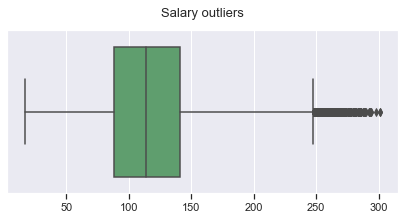

In [10]:
# Create plot object, create figure and call box plot function
pg = plotGraph()
fig1 = plt.figure(figsize=(7, 3))
pg.plotBox(data.train['salary'], fig1, 'Salary outliers', whis = 2.0)
plt.show()

In [11]:
# See categorical features statistics
catDF = data.objectCheck(data.train, 10, 'object')
catDF

jobType --> ['CFO', 'CEO', 'VICE_PRESIDENT', 'MANAGER', 'JUNIOR', 'JANITOR', 'CTO', 'SENIOR']
degree --> ['MASTERS', 'HIGH_SCHOOL', 'DOCTORAL', 'BACHELORS', 'NONE']
major --> ['MATH', 'NONE', 'PHYSICS', 'CHEMISTRY', 'COMPSCI', 'BIOLOGY', 'LITERATURE', 'BUSINESS', 'ENGINEERING']
industry --> ['HEALTH', 'WEB', 'AUTO', 'FINANCE', 'EDUCATION', 'OIL', 'SERVICE']




,count,unique,top,freq
jobId,999995,999995,JOB1362685059302,1
companyId,999995,63,COMP39,16193
jobType,999995,8,SENIOR,125886
degree,999995,5,HIGH_SCHOOL,236975
major,999995,9,NONE,532353
industry,999995,7,WEB,143205
yearsExperience,999995,25,15,40312
milesFromMetropolis,999995,100,99,10180
salary,999995,279,108,10467


* **Features distribution**

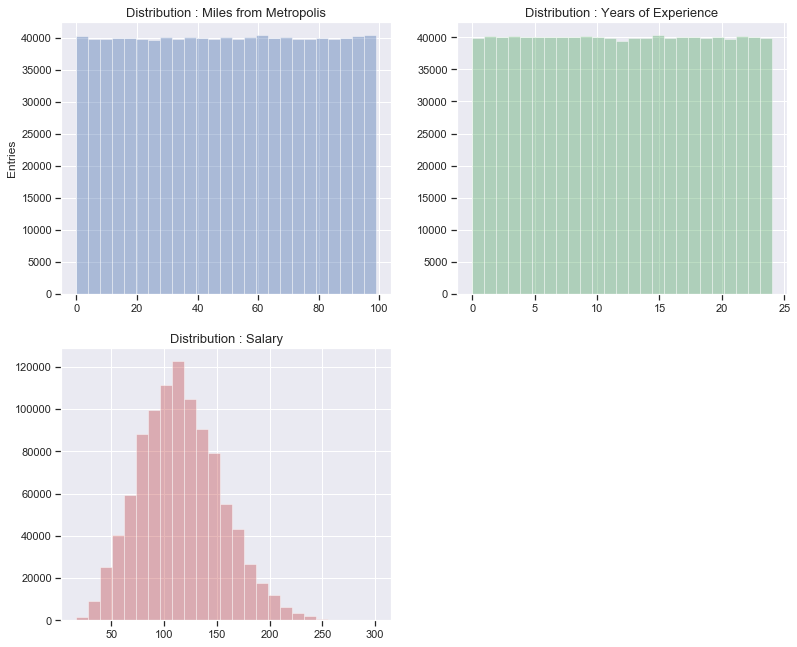

In [12]:
# Create figure and call distibution plot function for numerical features.
i = 0
fig1 = plt.figure(figsize=(13,11))
for col in [['milesFromMetropolis', 'Miles from Metropolis'],
            ['yearsExperience', 'Years of Experience'],['salary', 'Salary']]:
    pg.plotDist(data.train[col[0]], fig1.add_subplot(2,2,i+1), 'Distribution : {}'.format(col[1]), 
                bins = 25, plotC = plotColor[i], yLbl = '' if i != 0 else 'Entries')
    i +=1
plt.show()

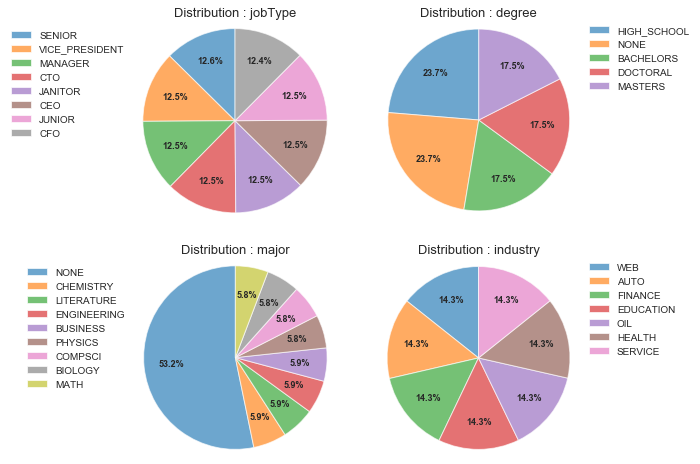

In [13]:
# Create figure, create data and call pie plot function
i = 1
fig1= plt.figure(figsize = (8,8))
for item in data.catCols:   
    if len(data.train[item].unique()) < 10 :
        tmpDF = data.train.groupby(item).count().sort_values(by='salary', ascending = False)
        ax = fig1.add_subplot(2,2,i)
        pg.plotPie(tmpDF['salary'], ax, pieColors, 'Distribution : {}'.format(item), 
                   legLoc = [1, 1.025] if i % 2 == 0 else [0,1], titleFS = 13 ,pieFS = 9, pct = True)        
        i += 1
plt.show()

* **Correlation matrix**

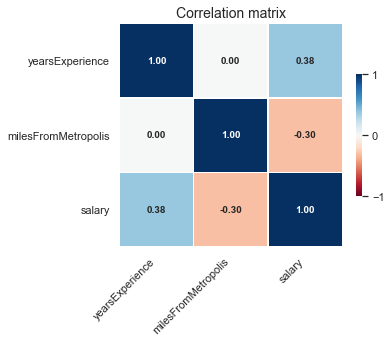

In [14]:
# Create figure and call correlation plot function
fig1= plt.figure(figsize = (5,5))
pg.plotCorr(data.train.corr(), fig1, 'Correlation matrix', titleFS = 14, cmap = 'RdBu', ticksFS = 11, 
            rot = 45,cbarD={'shrink': 0.45, 'ticks':[-1,0,1]}, annD={'size': 10, 'weight' : 'bold'},
            yLim = [1.2,0.0])
plt.show()

## 4. Exporatory data analysis

* **Features statistics analysis**

In [15]:
# Generate range of salary per company and call range function
tmpDF = data.aggData(data.train,'companyId','salary',np.mean)
tmpDF2 = data.aggData(data.train,['companyId','jobType'],'salary',
                      np.mean, sortL=['companyId','jobType'], asc=False)
tmpDF2 = data.pivotData(tmpDF2, 'jobType','companyId','salary')
tmpDF3 = data.rangeAnalysis(tmpDF, 'salary', tmpDF2)
tmpDF3

Min mean salary per company -->115.34
Max mean salary per company -->116.79
Range between --> 1.45
Salary range mean per company and jobType --> 3.23



companyId,Min,Max,Range
jobType,,,
CEO,143.252708,147.632727,4.380020
CFO,133.896570,137.330107,3.433537
CTO,133.918050,137.123925,3.205875
JANITOR,69.481382,71.996976,2.515594
JUNIOR,93.744734,96.569827,2.825093
MANAGER,114.172959,117.280284,3.107325
SENIOR,103.640387,107.143808,3.503421
VICE_PRESIDENT,123.956219,126.814834,2.858615


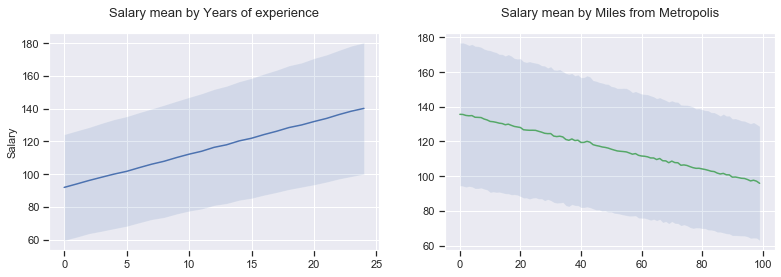

In [16]:
# Create figure, data list and call mean plot function
fig1 = plt.figure(figsize=[13,4])
lstF = ['yearsExperience', 'milesFromMetropolis']
lstFN = ['Years of experience', 'Miles from Metropolis']
pg.setStyle('darkgrid')
for i in range(len(lstF)):
    meanDF = data.aggData(data.train,lstF[i],'salary',np.mean)
    stdDF = data.aggData(data.train,lstF[i],'salary',np.std)
    pg.plotMean(meanDF['salary'], stdDF['salary'], fig1.add_subplot(1,2,i+1), '', 
                'Salary' if i == 0 else '', 'Salary mean by {}'.format(lstFN[i]), 
                lblFS = 11, titleFS = 13, plotC = plotColor[i])
plt.show()

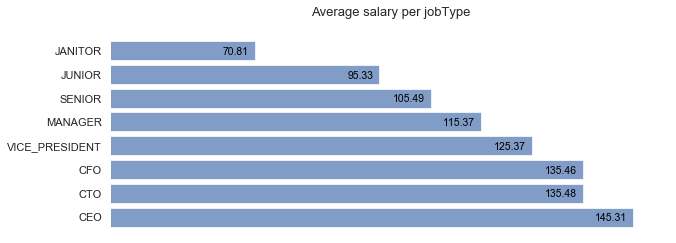

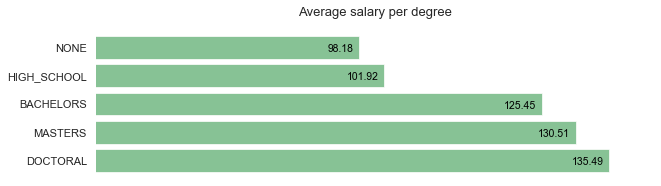

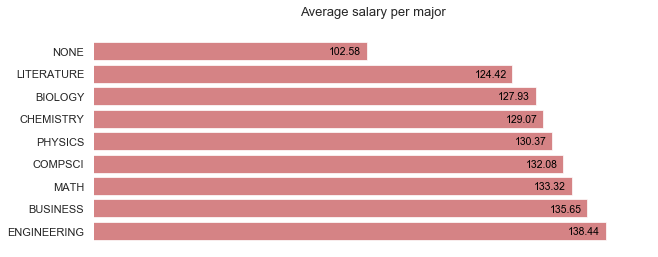

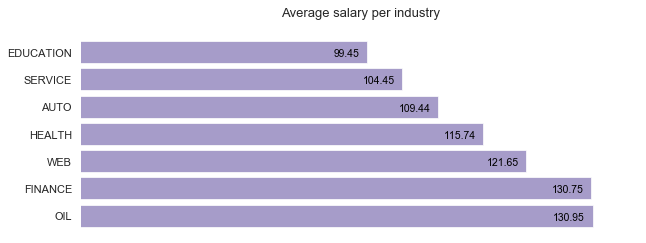

In [17]:
# Create data list and call barH function
i = 0
for item in data.catCols:
    lenCat = len(data.train[item].unique())
    if lenCat <10 :
        tmpDF = data.aggData(data.train,item,'salary',np.mean, 
                              sort = 'salary', asc = False)
        figH = 2.75 if lenCat < 6 else 3.75
        figH = 4 if lenCat > 8 else figH
        fig1 = plt.figure(figsize=(10, figH))
        pg.plotBarH(tmpDF[item],tmpDF['salary'],fig1,'Average salary per '+item,
                    0.85, 1, nType = 'double', plotC = plotColor[i], fontS = 10.5, 
                    sep = [3.75, 4.25] if i == 0 else [2.75, 3.25])
        i +=1
plt.show()

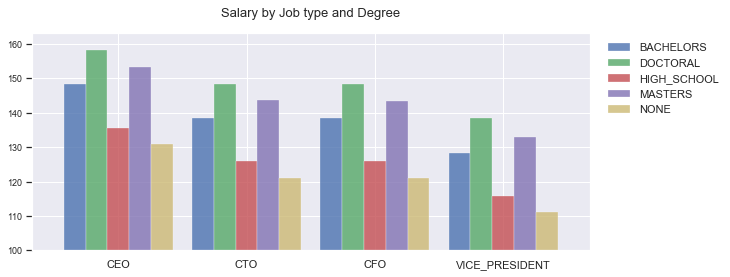

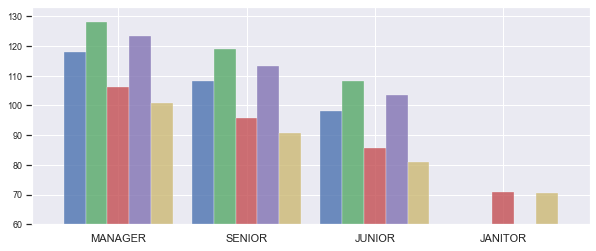

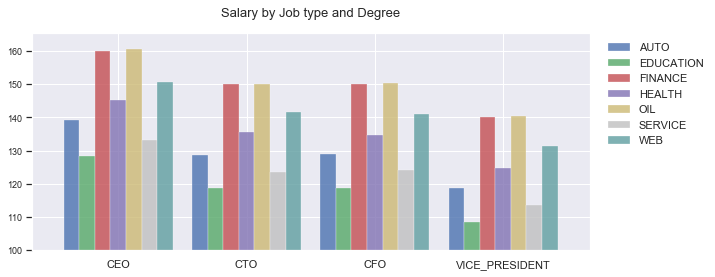

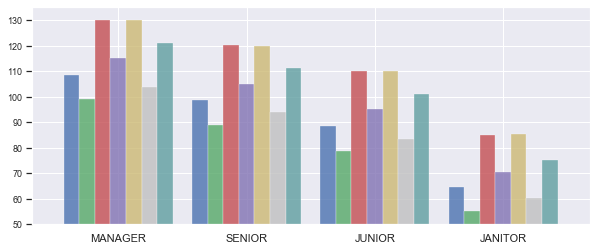

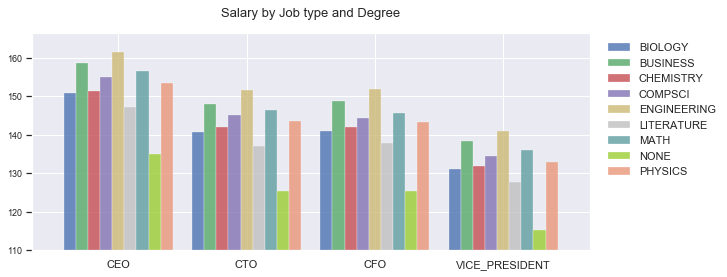

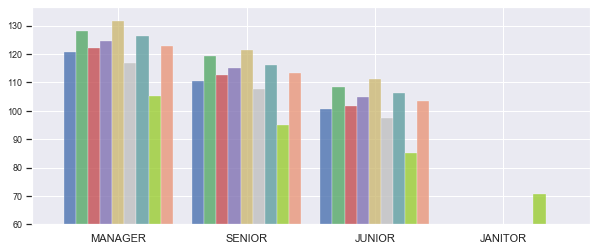

In [18]:
# Create data and call multibar plot function
i = 0
lstAgg = [['degree', 'jobType'], ['industry', 'jobType'],['major', 'jobType']]
lstCol = [['CEO','CTO', 'CFO', 'VICE_PRESIDENT'],
          ['MANAGER','SENIOR', 'JUNIOR', 'JANITOR']]
lstTitles = ['Job type and Degree', 'Job type and Industry','Job type and Major']
for aggV in lstAgg:
    tmpDF = data.aggData(data.train,aggV,'salary',np.mean)
    tmpDF = tmpDF.pivot(index=aggV[1], columns=aggV[0], values='salary')
    strTitle = 'Salary by {}'.format(lstTitles[i])
    bLeg = True
    for df in [tmpDF.loc[lstCol[0]],tmpDF.loc[lstCol[1]]]:
        yLim = (np.min(df.min())-5, np.max(df.max())+5)
        pg.plotMultBar(df, [10,4], strTitle, yLim, yTicksFS = 9, bLeg = bLeg, legLoc = [1.015,1])
        strTitle = ''
        bLeg = False

## 5. Data pre-processing

* **Feature engeenering, categorical features and data normalization**

### Feature engeenering ###

hasMajor feature created
compID feature created
jobIndDegMajYex_mean feature created
jobIndDegMajYex_std feature created
jobIndDegMajYex_min feature created
jobIndDegMajYex_max feature created

### Categorical features ###

Categorical features converted

### Data Normalization ###

Normalized datasets created

### Principal component analysis (PCA) ###



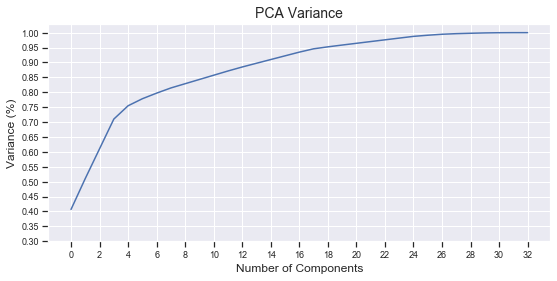

In [19]:
# Create data engineering object, needed data and prepare data for modeling
dEng = dataEng()
NewFt = 'jobIndDegMajYex'
lstDmy = ['hasMajor','major', ['NONE', 0, 1], True]
lstCmpID = ['compID', 'companyId', True, 'int64']
lstDtype = ['yearsExperience', 'yExpS']
lstAggFn = [[np.mean, '_mean'], [np.std, '_std'], [np.min, '_min'],[np.max, '_max']]
lstAggGr = ['jobType', 'industry', 'degree', 'major', 'yExpS']
lstFeat = ['jobType', 'degree', 'major', 'industry']
lstAx = ['Number of Components', 'Variance (%)']
fig1 = plt.figure(figsize=[9,4])
dEng.prepareData(NewFt, lstDmy, lstCmpID, lstDtype, lstAggFn, 
                 lstAggGr, lstFeat, lstAx, fig1)

## 6. Model development

* **Baseline**

In [21]:
# Create a baseline to compare
modelH = modelHandler(cv = 4)
modelH.baseline(data.trainC, data.targ['salary'],['jobType', 'companyId'], np.mean, 'Pred')

Baseline MSE --> 963.4481
Baseline RMSE --> 31.0395


* **Best model selection, feature importance and predictions**

Evaluating Linear Regression...
Evaluating Random Forest...
Evaluating XGBoost...

Results
-------

Linear Regression model.
     - MSE  --> 359.4430
     - RMSE  --> 18.9590

Random Forest model.
     - MSE  --> 340.5944
     - RMSE  --> 18.4552

XGBoost model.
     - MSE  --> 339.3565
     - RMSE  --> 18.4216

== BEST MODEL ==

     XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.975,
             early_stopping_rounds=15, gamma=0, importance_type='gain',
             learning_rate=0.057, max_delta_step=0, max_depth=4,
             min_child_weight=8, missing=None, n_estimators=150, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=16,
             reg_alpha=72, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.925, verbosity=1)

Fitting model to train data...


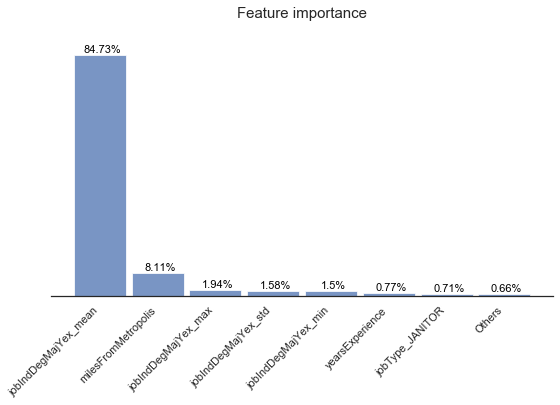


Predicting with test data...
Predictions exported
Process completed!


In [22]:
# Update base models with tunned hyperparameters
modelH.regRF = RandomForestRegressor(max_features = 0.5, max_depth = 10,  n_estimators = 500,
                                     min_samples_split = 8, min_samples_leaf = 8,
                                     random_state = rndSt)
modelH.regXGB = xgb.XGBRegressor(learning_rate =0.057, n_estimators=150, max_depth=4, gamma=0,
                                 min_child_weight=8, subsample = 0.925, colsample_bytree = 0.975, 
                                 reg_alpha =  72, early_stopping_rounds = 15, random_state = rndSt, 
                                 objective = 'reg:squarederror')

# Create data and call function that evaluates models and prints results
lstModel = [[modelH.regLR, 'Linear Regression'],
            [modelH.regRF, 'Random Forest'],
            [modelH.regXGB, 'XGBoost']]
fig1 = plt.figure(figsize=[9,5])
bestM = modelH.modelSelection(lstModel, data.trainN, data.targ['salary'], data.testN, fig1)